# Electron-phonon coupling (First order perturbation.)

Here we show the electron-phonon coupling affect the electron band structure. 
The Hamiltonian can be written as 
$H=H_0+\frac{\partial H}{\partial A} A$, where $H_0$ is the unperturbated hamiltonian, and A is the phonon amplitude. For each eigen state $|\psi_0(k)>$ of $H_0(k)$, the first order perturbation to the eigen energy is:
$<\psi_0(k)|\frac{\partial V}{\partial A}|\psi_0(k)>$.
Again we take the 1d H atom chain as an example. 

A fatband of the band shift can be plotted to show the shift of each eigen energy. 

In [1]:
%matplotlib inline
import numpy as np
from  minimulti.electron.Hamiltonian import etb_model, atoms_model
from minimulti.electron.epc import EPC
from minimulti.electron.basis2 import BasisSet, gen_basis_set, atoms_to_basis
from ase.atoms import Atoms
import matplotlib.pyplot as plt


def plot_epc(t=1,  dtdx=0.1, dx=0.0, nel=1, order=1):
    # generate structure.
    atoms=Atoms(symbols='H', positions=[(0,0,0)], cell=[1,1,1])
    # generate basis set
    bset= atoms_to_basis(atoms, basis_dict={'H': ('s',)}, nspin=2)
    # generate model
    mymodel=atoms_model(atoms=atoms, basis_set=bset, nspin=2)

    # make supercell
    sc_matrix=np.diag([1,1,2])
    nsc=np.linalg.det(sc_matrix)
    mymodel=mymodel.make_supercell(sc_matrix)
    # onsite energy (tune v to make electron localized on one site)
    # mymodel.set_onsite(v,0)
    # mymodel.set_onsite(v,1)

    # 1D hopping along z. Format: t, i, j, R.
    # spin up
    mymodel.set_hop(t-dtdx*dx, 0,2, [0,0,0])
    mymodel.set_hop(t+dtdx*dx, 2,0,[0,0,1])
    # spin down
    mymodel.set_hop(t-dtdx*dx, 1,3, [0,0,0])
    mymodel.set_hop(t+dtdx*dx, 3,1, [0,0,1])
    mymodel.set(nel=nel*nsc, mixing=0.5, tol_energy=1e-8, tol_rho=1e-8, sigma=0.1)
    mymodel.set_Hubbard_U(Utype='Dudarev', Hubbard_dict={'H':{'U':0, 'J':0}})

    # K mesh.
    mymodel.set_kmesh([1,1,30])

    # Scf solve
    mymodel.scf_solve(print_iter_info=False)
    efermi=mymodel.get_fermi_level()
    
    # Electron phonon coupling term.
    epc_nospin=EPC(norb=2)
    epc_nospin.add_term(R=(0,0,0), i=0, j=1,val=-dtdx)
    epc_nospin.add_term(R=(0,0,1), i=1, j=0,val=dtdx)
    #epc_nospin.add_term(R=(0,0,0), i=0, j=1,val=dt)
    #epc_nospin.add_term(R=(0,0,0), i=0, j=1,val=dt)
    epc_spin=epc_nospin.to_spin_polarized()

    #shift=epc_spin.get_band_shift(kpts, evecs, mymodel.bset.get_positions())
    #print(shift)
    #print(epc_spin._epc)
    
    kpt_x=np.arange(0, 1.01,0.001)
    kpts=[np.array([0,0,1]) * x for x in kpt_x]
    evalues, evecs=mymodel.solve_all(k_list=kpts)

    ax=epc_spin.plot_epc_fatband(kpts, evalues, evecs,   kpt_x,order=order, X=[0,1], xnames=['0','1'], show=False, efermi=efermi, width=2)
    for i in range(mymodel._norb):
        ax.plot(kpt_x, evalues[i,:], color='green', linewidth=0.1)
    ax.set_xlabel('k-point')
    ax.set_ylabel('Energy')
    ax.axhline(efermi, linestyle='--', color='gray')

    plt.show()
    

For dx=0, we can see below that from first order perturbation the shift of the bands are zero everywhere due to symmetry. Second order perturbation is needed in this case to see the band shift.

/home/hexu/projects/minimulti/minimulti/electron/epc.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[:, ik] = Pert.Epert1(evecs_ik, Hk)


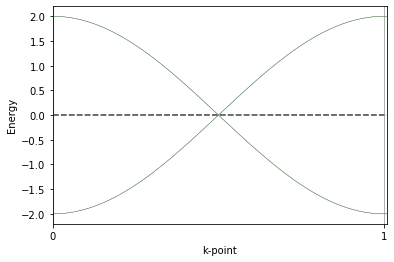

In [2]:
plot_epc(t=1,  dtdx=0.5, dx=0.0, nel=1)

For dx$\neq$0, the band shift is shown below. The red and blue colors show the sign of the shift: negative and positive respectively. We can see the opening of the band gap as dx increases. Also we can see that at $k=0$ and $k=1$, the band shift is zero. Whereas the maximum band shift is at $k=0.5$. 
Note that here the BZ has the unit of $2\pi/2a$ since we take two H atom as the unitcell. If we use the single H atom as the unitcell, then the phonon has a wavevector of 1/2, and the maximum band shift will be at 1/4, which is half of the phonon wave vector.

In [3]:
#plot_epc(t=1,  dtdx=0.5, dx=0.4, nel=1)
from ipywidgets import FloatSlider, interact, interact_manual, fixed
interact(plot_epc, t=fixed(1), dtdx=fixed(1), dx=(-1.0,1.0,0.1), nel=fixed(1), order=[1,2]);

interactive(children=(FloatSlider(value=0.0, description='dx', max=1.0, min=-1.0), Dropdown(description='order…